Variational Linear Regression

This notebook shows how to implement the variational linear regression model with optimized output value variance according to the derivation in PRML.

Application of the model is demonstrated using samples generated by a sinusoidal function with Gaussian noise.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import special

np.random.seed(seed=0)

# Data

The data consists of 1D input features $x$ paired with a observed noisy target value $y$.

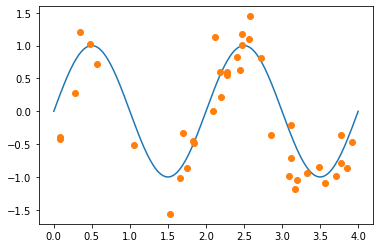

In [2]:
obs_N = 40
x_range_min = 0.
x_range_max = 4.
x = np.random.random(obs_N) * (x_range_max - x_range_min)

t_var = 0.4
t_noise = np.random.normal(scale=t_var, size=obs_N)

t = np.zeros(obs_N)

for i in range(obs_N):
    t[i] = np.sin(x[i] * np.pi) + t_noise[i]

x_dense = np.linspace(x_range_min, x_range_max, 200)
y_true = np.sin(np.pi*x_dense)
plt.plot(x_dense, y_true)
plt.plot(x, t, 'o')
plt.show()

### Linear basis function model

Applying a fixed nonlinear transformation on the input variable vectors $x$ to generate feature vectors $\phi$, allowing the model to consider linear combinations of fixed nonlinear functions of the input variables.

In [3]:
def input2feature(x, mean, std):
    '''
    Args:
        input_vec: Input vector of shape (1,1)
        
    Returns:
        feat_vec: Feature vector of shape(4,1)
    '''
    
    input_vec = (x - mean) / std
    
    input_vec = np.array(input_vec)
    
    feat_vec = np.zeros((7,1))
    
    feat_vec[0,0] = input_vec
    feat_vec[1,0] = input_vec**2
    feat_vec[2,0] = input_vec**3
    feat_vec[4,0] = input_vec**4
    feat_vec[5,0] = input_vec**5
    feat_vec[6,0] = 1.0
    
    return feat_vec

In [4]:
phis = np.zeros((input2feature(x[0], 1., 1.).shape[0], obs_N))

mean = np.mean(x)
std = np.std(x)

print(f"mean {mean}, std {std}")

for n in range(obs_N):
    phis[:,n:n+1] = input2feature(x[n], mean, std)

# Number of features
D = phis.shape[0]

ts = np.zeros((obs_N,1))
ts[:,0] = t

mean 2.2988006826188063, std 1.0895852891320816


### Labels

Stored as an (1,N) array with each column $n$ corresponding to label $t$ of example $n$.

<table style="border:1">
    <tr>
        <td>$y^{(1)}$</td>
        <td>$y^{(2)}$</td>
        <td>$\dots$</td>
        <td>$y^{(N)}$</td>
    </tr>
</table>

### Summary of data

In [5]:
print(f"Feature array 'phis' : {phis.shape}")
print(f"Label array 'ts'     : {ts.shape}")
print(f"    #Samples  : {obs_N}")
print(f"    #Features : {D}")

Feature array 'phis' : (7, 40)
Label array 'ts'     : (40, 1)
    #Samples  : 40
    #Features : 7


# Expectations

In [6]:
def alpha_expectation(a_N, b_N):
    '''Returns the expected value of a Gamma distribution defined by parameters 'a_N' and 'b_N'.
    
    Ref: Bishop Eq 10.102 (p.488)
    '''
    return a_N / b_N


def beta_expectation(c_N, d_N):
    '''Returns the expected value of a Gamma distribution defined by parameters 'c_N' and 'd_N'.
    
    Ref: Equiv. to Bishop Eq 10.102 (p.488)
    '''
    return c_N / d_N


def gaussian_quadratic_expectation_wrt_w(mu_N, sigma_N):
    '''Returns the expected value of the quadratic weight vectors for a Gaussian distribution w.r.t. weights.
    
    Because we are taking the expectations w.r.t. weights, other unrelated terms can be dropped from the general expectation.
    
    Ref: Bishop Eq 10.183 (p.505)
    '''
    return np.matmul(mu_N.T, mu_N) + np.trace(sigma_N)

# Maximization (re-estimation) equations

$$q^*(w) = \mathcal{N}( w | \mu_N, \Sigma_N )$$

where

$${\mu}_N = \mathbb{E}[\beta] \: \Sigma_N \Phi^T t$$

$$\Sigma_N = \left( \mathbb{E}[\beta] \: \Phi^T \Phi + \mathbb{E}[\alpha] \: I \right)^{-1}$$

In [7]:
def estim_qw_distr(phis, ts, exp_alpha, exp_beta):
    '''Returns parameters for the re-estimated distribution which maximizes the lower bound.
    
    Args:
        phis:   : Feature matrix of shape (D,N)
        ts      : Label vector of shape (1,N)
        exp_alpha : Expected value of Gamma distribution modeling variance of 'p(w)'.
        exp_beta  : Expected value of Gamma distribution modeling variance of 'p(t)'.
        
    Returns:
        mu_N, sigma_N : Mean vector and covariance matrix of shapes (D,1) and (D,D)
    
    Ref: Bishop Eq. 10.96-10.98 (p.487)
    '''
    sigma_N = exp_beta * phis.T.dot(phis) + exp_alpha * np.eye(phis.shape[1])
    sigma_N = np.linalg.inv(sigma_N)
    
    mu_N = exp_beta * sigma_N.dot(phis.T).dot(ts)
    
    return mu_N, sigma_N

$$q^*(\alpha) = Gam(\alpha | a_N, b_N)$$

where

$$a_N = a_0 + \frac{D}{2}$$

$$b_N = b_0 + \frac{1}{2}  \mathbb{E}[w^T w]$$

In [8]:
def estim_qalpha_distr(a_0, b_0, exp_quad_w, D):
    '''Returns parameters for the re-estimated distribution which maximizes the lower bound.
    
    Args:
        a_0 : Value of initial variational hyperpriors for alpha distr.
        b_0 : 
        exp_quad_w : The expected value of the quadratic weight vectors for a Gaussian distribution w.r.t. weights.
        D : Number of model parameters (i.e. length of mu_N)
        
    Returns:
        a_N, b_N : Scalar parameters
        
    Ref: Bishop Eq. 10.93-10.95 (p.487)
    '''
    a_N = a_0 + 0.5*D
    b_N = b_0 + 0.5*exp_quad_w
    
    return a_N, b_N

$$q^*(\beta) = Gam(\beta | c_N, d_N)$$

where

$$c_N = c_0 + \frac{N}{2}$$

$$d_N = d_0 + \frac{1}{2} \left( || \Phi \mu_N - t ||^2 + Tr[\Phi^T \Phi \Sigma_N] \right)$$

In [9]:
def estim_qbeta_distr(c_0, d_0, phis, ts, mu_N, sigma_N, N):
    '''Returns parameters for the re-estimated distribution which maximizes the lower bound.
    
    Args:
        c_0     : Value of initial variational hyperpriors for beta distr.
        d_0     : 
        phis    : Feature matrix of shape (D,N).
        ts      : Label vector of shape (1,N)
        mu_N    : Mean vector for weight distribution 'q(w)' of shape (D,1)
        sigma_N : Covariance matrix for weight distribution 'q(w)' of shape (D,D)
        N       : Number of samples (i.e. observations)
    
    Returns:
        c_N, d_N : Scalar parameters
    '''
    c_N = c_0 + 0.5*N
    d_N = d_0 + 0.5*(np.linalg.norm(phis.dot(mu_N) - ts)**2 + np.trace(phis.T.dot(phis).dot(sigma_N)))
    
    return c_N, d_N

# Expectation Maximization iteration

In [10]:
def comp_lower_bound(phis, ts, mu_N, sigma_N, exp_beta, a_0, b_0, c_0, d_0, a_N, b_N, c_N, d_N, D):
    
    term_1 = 0.5 * np.log(exp_beta / (2.*np.pi)) - 0.5 * exp_beta * ts.T.dot(ts) + exp_beta * mu_N.T.dot(phis.T).dot(ts) - 0.5 * exp_beta * np.trace(phis.T.dot(phis).dot( mu_N.dot(mu_N.T) + sigma_N ))
    term_2 = -0.5*D * np.log(2.*np.pi) + 0.5*D*(special.digamma(a_N) - np.log(b_N)) - (a_N / (2.*b_N)) * (mu_N.T.dot(mu_N) + np.trace(sigma_N))
    term_3 = a_0 * np.log(b_0) + (a_0 - 1.)*(special.digamma(a_N) - np.log(b_N)) - b_0*(a_N/b_N) - np.log(special.gamma(a_N))
    term_4 = c_0 * np.log(d_0) + (c_0 - 1.)*(special.digamma(c_N) - np.log(d_N)) - d_0*(c_N/d_N) - np.log(special.gamma(c_N))
    term_5 = -0.5*np.log(np.linalg.det(sigma_N)) - 0.5*D*(1. + np.log(2.*np.pi))
    term_6 = -np.log(special.gamma(a_N)) + (a_N - 1.)*special.digamma(a_N) + np.log(b_N) - a_N
    term_7 = -np.log(special.gamma(c_N)) + (c_N - 1.)*special.digamma(c_N) + np.log(d_N) - c_N
    
    lower_bound = term_1 + term_2 + term_3 + term_4 - term_5 - term_6 - term_7
    # Return scalar
    return lower_bound[0,0]


In [11]:
# Model formulated in terms of a (N, D) feature matrix
phis = phis.T

iter 1 | 66.99962318583096
iter 2 | 75.77558295997372
iter 3 | 80.47445462641596
iter 4 | 81.56949461436426
iter 5 | 82.7769011944563
iter 6 | 83.09563963901657
iter 7 | 83.41587485760255
iter 8 | 83.50897121125338
iter 9 | 83.59186538437581
iter 10 | 83.61842746337989
iter 11 | 83.64171010827997
iter 12 | 83.64971287880823
iter 13 | 83.65659438283524
iter 14 | 83.65907499442133
iter 15 | 83.66114988558604
iter 16 | 83.66192578948764
iter 17 | 83.66255586998827
iter 18 | 83.6627989958709
iter 19 | 83.66299086275582
iter 20 | 83.66306700864726
iter 21 | 83.66312551434258
iter 22 | 83.6631493370979
iter 23 | 83.66316719329471
iter 24 | 83.66317463765684
iter 25 | 83.66318009144382
iter 26 | 83.6631824151213
iter 27 | 83.66318408195382
iter 28 | 83.66318480652005


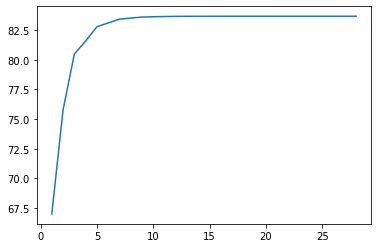

In [12]:
#######################
#  Initial variables
#######################

# Hyperpriors for Gamma distributions
a_0 = 1.
b_0 = 1.
c_0 = 1.
d_0 = 1.

a_N = a_0
b_N = b_0
c_N = c_0
d_N = d_0

mu_N = np.random.random((D,1))
sigma_N = np.eye(D)

lower_bound_prev = np.inf
lower_bound_list = []

conv_criteria = 1e-6

for iter_idx in range(1,201):
    
    # Expectation step
    exp_alpha = alpha_expectation(a_N, b_N)
    exp_beta = beta_expectation(c_N, d_N)
    exp_quad_w = gaussian_quadratic_expectation_wrt_w(mu_N, sigma_N)
    
    # Maximization step
    mu_N, sigma_N = estim_qw_distr(phis, ts, exp_alpha, exp_beta)
    a_N, b_N = estim_qalpha_distr(a_0, b_0, exp_quad_w, D)
    c_N, d_N = estim_qbeta_distr(c_0, d_0, phis, ts, mu_N, sigma_N, obs_N)
    
    # Lower bound
    lower_bound = -comp_lower_bound(phis, ts, mu_N, sigma_N, exp_beta, a_0, b_0, c_0, d_0, a_N, b_N, c_N, d_N, D)
    lower_bound_list.append((iter_idx, lower_bound))
    
    if iter_idx % 1 == 0:
        print(f"iter {iter_idx} | {lower_bound}")
    
    # Check convergence
    if (np.abs(lower_bound - lower_bound_prev) < conv_criteria):
        break
    else:
        lower_bound_prev = lower_bound
    
# Plot lower bound convergence
iters = [entry[0] for entry in lower_bound_list]
lower_bounds = [entry[1] for entry in lower_bound_list]
plt.plot(iters, lower_bounds)
plt.show()

# Predictive posterior $p(t^{new} | \phi^{new}, \mathbb{D})$

In [13]:
def predictive_posterior_distr(x, mu_N, sigma_N, beta, basis_func, mean, std):
    '''Computes the probability distribution representing the output value of a feature vector
    '''
    phi = basis_func(x,mean, std)
    
    mu = mu_N.T.dot(phi)
    sigma2 = 1./beta + phi.T.dot(sigma_N).dot(phi)
    return mu, sigma2

4.20259917715548
0.2379479835802109


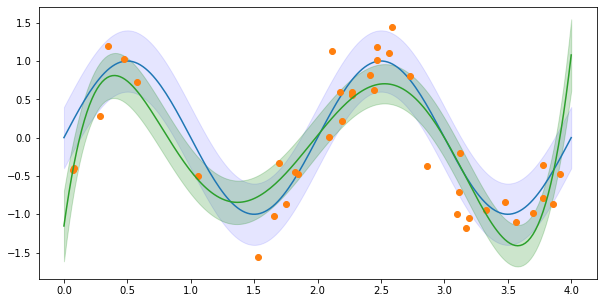

In [14]:
beta = beta_expectation(c_N, d_N)
print(beta)
print(1/beta)
N = 200
x_array = np.linspace(x_range_min, x_range_max, N)
mu_array = np.zeros(N)
sigma2_array = np.zeros(N)

for i in range(x_array.shape[0]):
    
    mu_i, sigma2_i = predictive_posterior_distr(x_array[i], mu_N, sigma_N, beta, input2feature, mean, std)
    
    mu_array[i] = mu_i
    sigma2_array[i] = sigma2_i

plt.figure(figsize=(10,5))
plt.plot(x_dense, y_true)
plt.fill_between(x_dense, y_true - t_var, y_true + t_var, alpha=.1, color="blue")
plt.plot(x, t, 'o')
plt.plot(x_array, mu_array)
plt.fill_between(x_array, mu_array - sigma2_array, mu_array + sigma2_array, alpha=0.2, color="green")

plt.show()